In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

import torch
from torch import vmap

from src.energies.base_prior import MeanFreePrior

from src.models.components.clipper import Clipper
from src.utils.data_utils import remove_mean

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [5]:
n_particles = 13
spatial_dim = 3
dimensionality = spatial_dim * n_particles
inverse_temp = 4.0

from src.energies.lennardjones_energy import LennardJonesEnergy
target = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/",
    smooth=False,
    temperature=inverse_temp
    )

In [35]:
t_07 = 0.7
target_temp_07 = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/",
    smooth=False,
    temperature=t_07
    )

t_08 = 0.8
target_temp_08 = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/",
    smooth=False,
    temperature=t_08
    )

target_temp_2 = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/",
    smooth=False,
    temperature=2.0
    )


target_temp_1 = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/",
    smooth=False,
    temperature=1.0
    )

## Function Definitions

In [8]:
from scipy.stats import qmc
sampler = qmc.Sobol(d=1, scramble=False)

def sample_cat(bs, next_u, logits):
    # u, next_u = sample_uniform(bs, next_u)
    u = sampler.random(bs).squeeze()
    clipped_weights = torch.clip(torch.softmax(logits, dim=-1), 1e-6, 1.0)
    bins = torch.cumsum(clipped_weights, dim=-1)
    ids = np.digitize(u, bins.cpu())
    ids = torch.tensor(ids, dtype=torch.long).to(device)
    return ids, next_u


def sample_cat_sys(bs, next_u, logits):
    u = torch.rand(size=(1,), dtype=torch.float64)
    u = (u + 1/bs*torch.arange(bs)) % 1.0
    clipped_weights = torch.clip(torch.softmax(logits, dim=-1), 1e-6, 1.0)
    bins = torch.cumsum(clipped_weights, dim=-1)
    ids = np.digitize(u, bins.cpu())
    return ids, None

In [9]:
class VEReverse_coupled(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, model, noise_schedule):
        super().__init__()
        self.model = model
        self.noise_schedule = noise_schedule

    def f(self, t, x, resampling_interval=None, inverse_temp=1.0):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)

        with torch.enable_grad():
            x.requires_grad_(True)
            t.requires_grad_(True)
            epsilon_t = self.g(t, x).pow(2) / 2 

            nabla_Ut = self.model(t, x)
            drift_X = nabla_Ut * self.g(t, x).pow(2).unsqueeze(-1)

            drift_A = torch.zeros(x.shape[0]).to(x.device)
            
            if resampling_interval is None:
                return  drift_X.detach(), drift_A.detach()
            
            drift_A = epsilon_t * (-nabla_Ut.pow(2).sum(-1) * (inverse_temp-1) * inverse_temp)
        return  drift_X.detach(), drift_A.detach()

    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g

def euler_maruyama_step_coupled(sde, x, t, a, dt, step, diffusion_scale,
                                resampling_interval, inverse_temp, u_next):
    # Calculate drift and diffusion terms
    drift_Xt, drift_At = sde.f(t, x, resampling_interval, inverse_temp)
    drift_Xt = drift_Xt * dt * inverse_temp
    drift_At = drift_At * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones_like(x).to(device)
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device) * diffusion_scale

    # Update the state
    x_next = x + drift_Xt + diffusion
    a_next = a + drift_At

    if resampling_interval is None or step % resampling_interval != 0:
        return x_next, a_next, u_next

    #resample based on the weights
    #choice, _ = sample_cat(x.shape[0], u_next, a_next)
    choice, u_next = sample_cat_sys(x.shape[0], u_next, a_next)
    a_next = torch.zeros_like(a_next)
    x_next = x_next[choice]
    
    return x_next, a_next, u_next


def integrate_sde_coupled(sde, x0, t_span, dt, diffusion_scale, 
                          resampling_interval, inverse_temp):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    logweights = []
    a = torch.zeros(x.shape[0]).to(device)
    u_next = 0.5
    with torch.no_grad():
        for step, t in enumerate(times):
            x, a, u_next = euler_maruyama_step_coupled(sde, x, 1-t, a, dt, step+1, diffusion_scale,
                                                       resampling_interval, inverse_temp, u_next)
            x = remove_mean(x, target.n_particles, target.n_spatial_dim)
            samples.append(x)
            logweights.append(a)
    return torch.stack(samples), torch.stack(logweights)


def generate_samples_weighted(reverse_sde, t_span=(0, 1), num_integration_steps=100,
                              samples=None, num_samples=200, diffusion_scale=1.0,
                              resampling_interval=None, inverse_temp=1.0):
    if samples is None:
        samples = prior.sample(num_samples)

    dt = 1 / num_integration_steps

    samples, weights = integrate_sde_coupled(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=dt,
        diffusion_scale=diffusion_scale,
        resampling_interval = resampling_interval,
        inverse_temp=inverse_temp
    )
    return samples[-1], weights

In [10]:
from src.models.components.score_estimator import estimate_grad_Rt
def reward_matching_loss(model,
                         energy,
                         x,
                         t,
                         noise_schedule,
                         num_mc_samples=100,
                         clipper=None,
    ):


    x.requires_grad = True
    h_t = noise_schedule.h(t.unsqueeze(1))
    
    # noisy sample: x(t)
    xt = torch.normal(x, h_t**0.5)

    # predicted score
    pred_scores = model(t, xt)

    estimated_scores = estimate_grad_Rt(
        t,
        xt,
        energy,
        noise_schedule,
        num_mc_samples=num_mc_samples,
    ).detach()

    if clipper is not None:
        estimated_scores = clipper.clip_scores(estimated_scores)

    err = (
        estimated_scores - pred_scores
    ) ** 2
    return err.mean()

### Training

In [16]:
from src.models.components.noise_schedules import GeometricNoiseSchedule, QuadraticNoiseSchedule
noise_schedule = GeometricNoiseSchedule(sigma_min=0.01, sigma_max=2)

noise_schedule = QuadraticNoiseSchedule(beta=10)
# noise_schedule = GeometricNoiseSchedule(sigma_min=0.001, sigma_max=8)

prior samples torch.Size([2048, 39])


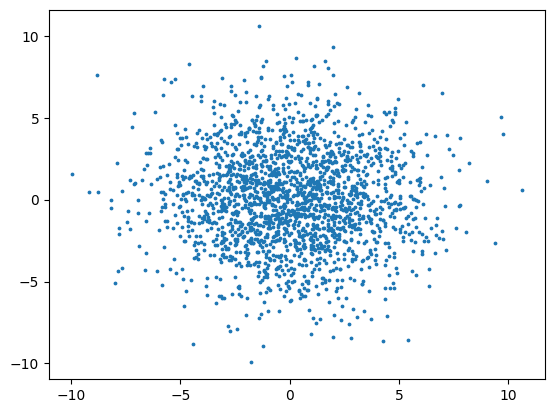

In [17]:
prior = MeanFreePrior(n_particles, spatial_dim, device=device, scale = noise_schedule.h(1) ** 0.5)
x1_samples = prior.sample(2048).detach().cpu()
plt.scatter(x1_samples[:, 0], x1_samples[:, 1], s=3)

print("prior samples", x1_samples.shape)

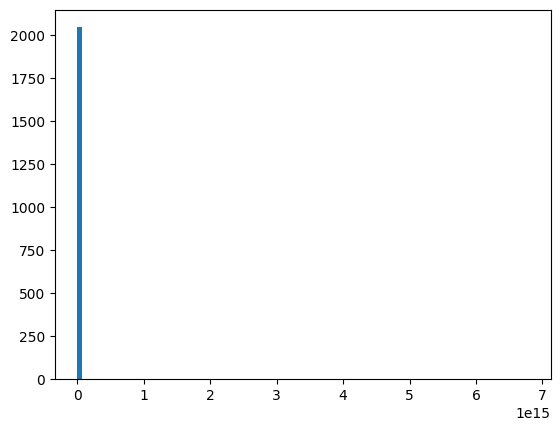

In [18]:
x1_enegry = target(x1_samples)
plt.hist(-x1_enegry.detach().cpu().numpy(), bins=100);

In [26]:
from src.models.components.prioritised_replay_buffer import SimpleBuffer
buffer = SimpleBuffer(
    dimensionality,
    10000,
    1000,
    initial_sampler=None,
    device=device,
    fill_buffer_during_init=False,
    sample_with_replacement=True,
    prioritize=False,
)

Buffer not initialised, expected that checkpoint will be loaded.


In [27]:
clipper = Clipper(
    should_clip_scores=True, should_clip_log_rewards=False, max_score_norm=1000
)
clipper.energy_function = target

In [28]:
outer_epochs= 50
inner_epochs = 100

batch_size = 1024

x1_samples_energy = target(x1_samples.detach())
buffer.add(x1_samples, x1_samples_energy)

train_dataset = TensorDataset(x1_samples.detach(), x1_samples_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

num_mc_samples = 1000

In [29]:
from src.models.components.egnn import EGNN_dynamics
model = EGNN_dynamics(n_particles=target.n_particles,
                      n_dimension=target.n_spatial_dim,
                      hidden_nf=64,
                      act_fn=torch.nn.SiLU(),
                      n_layers=3,
                      recurrent=True,
                      tanh=True,
                      attention=True,
                      condition_time=True,
                      agg='sum').to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 | Loss 9.161919
Epoch 49 | Loss 97.989822
Epoch 98 | Loss 92.222496


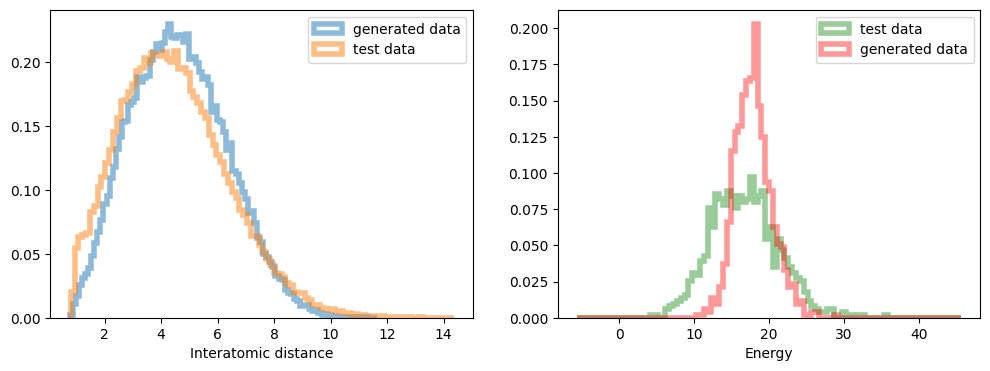

  2%|▏         | 1/50 [00:37<30:34, 37.44s/it]

Mean of Energy tensor(-17.9075, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 1.042735
Epoch 49 | Loss 2.824362
Epoch 98 | Loss 1.264110


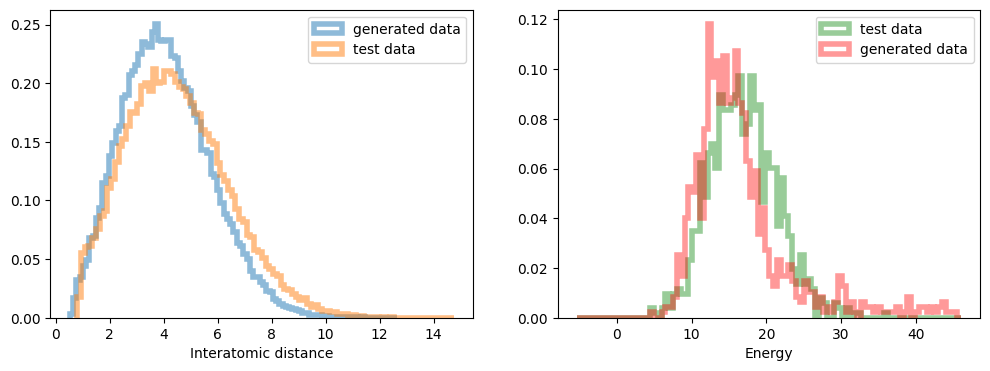

  4%|▍         | 2/50 [02:05<53:51, 67.33s/it]

Mean of Energy tensor(-25.1754, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 118.090271
Epoch 49 | Loss 45.843113
Epoch 98 | Loss 2.464958


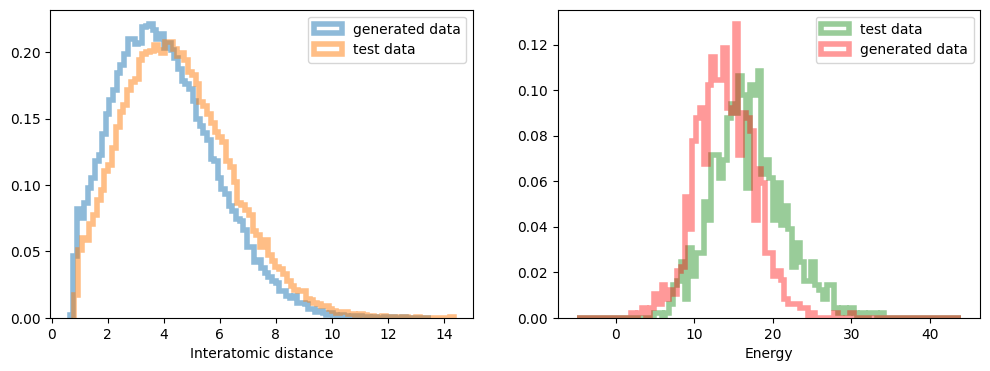

  6%|▌         | 3/50 [03:31<59:28, 75.92s/it]

Mean of Energy tensor(-14.3041, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 2.315084
Epoch 49 | Loss 1.205883


  6%|▌         | 3/50 [04:27<1:09:52, 89.21s/it]


KeyboardInterrupt: 

In [30]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            
            optimizer.zero_grad()

            t = torch.rand(len(samples)).to(device)
            rm_loss= reward_matching_loss(model, 
                                          target,
                                          samples,
                                          t, 
                                          noise_schedule, 
                                          num_mc_samples=num_mc_samples,
                                          clipper=clipper
                                          )
            
            loss = rm_loss.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the network
    ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
    samples, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=500,
                                           resampling_interval=None, num_samples=1000)
    samples_energy = target(samples)
    target.get_dataset_fig(samples)
    plt.show()


    # Update Buffer 
    buffer.add(samples,  samples_energy)

    print("Mean of Energy", samples_energy.mean())
    
    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(batch_size * 5)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

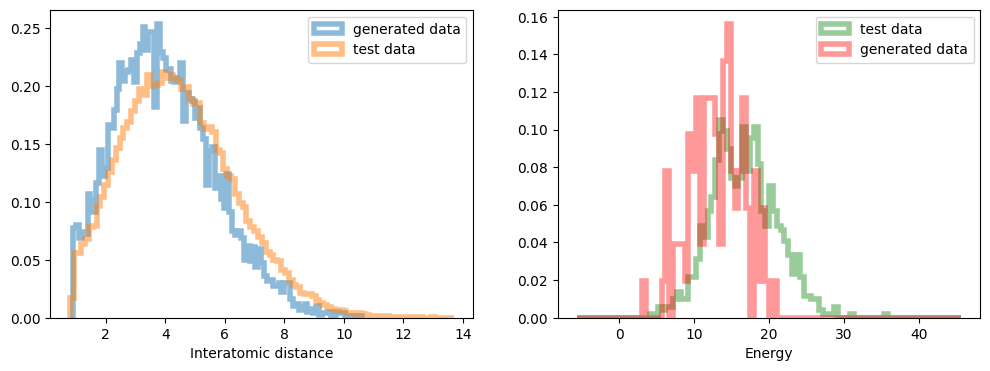

In [31]:
ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
samples, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=500,
                                    resampling_interval=None, num_samples=100)
samples_energy = target(samples)
target.get_dataset_fig(samples)
plt.show()

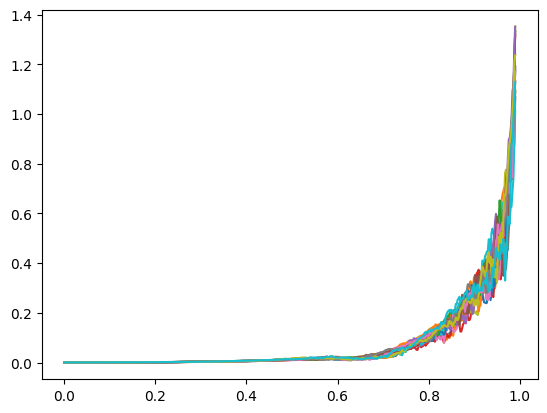

In [ ]:
drift_norm = torch.norm(drift, dim=-1)
plt.plot(torch.linspace(1, 0, 500)[5:], drift_norm.detach().cpu().numpy()[5:, :20]);

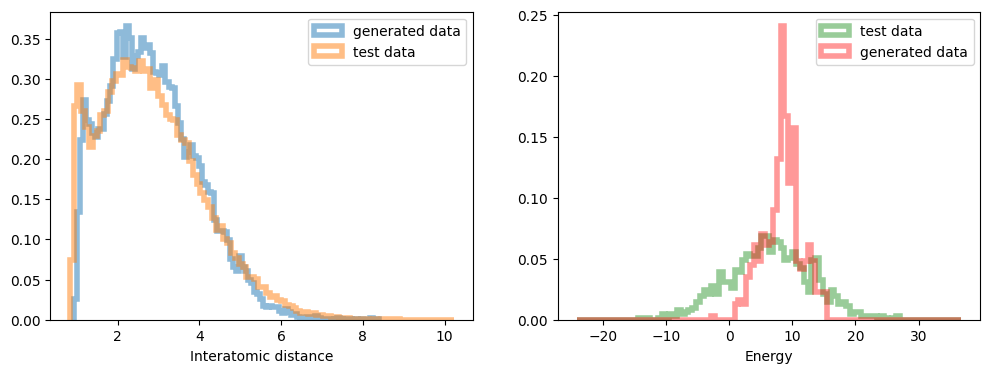

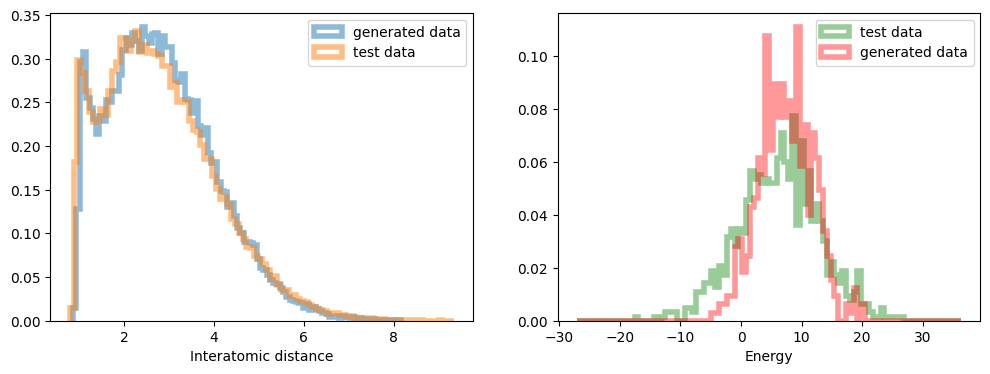

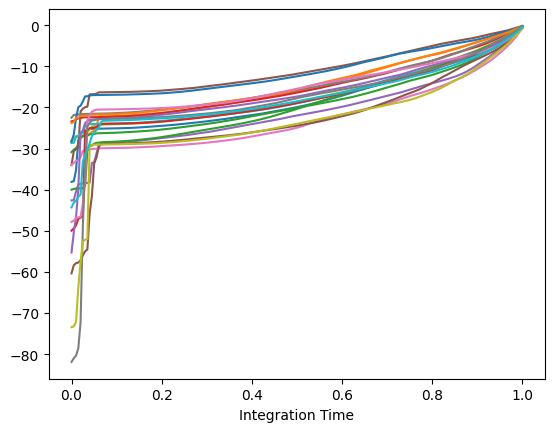

In [39]:
# for plotting

ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
n_steps = 200
samples_weighted = []
samples = []
log_weights = []
for i in range(1):
    prior_samples = prior.sample(512)
    s_weighted, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=prior_samples,
                                                    num_integration_steps=n_steps, resampling_interval=1, inverse_temp=2.0)
    s, w = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=prior_samples,
                                            num_integration_steps=n_steps, resampling_interval=n_steps+1, inverse_temp=2.0)
    samples_weighted.append(s_weighted)
    samples.append(s)
    log_weights.append(w)

samples_weighted = torch.cat(samples_weighted)
samples = torch.cat(samples)
log_weights = torch.cat(log_weights, dim=1)

target_temp_2.get_dataset_fig(samples_weighted)
# target_temp1.get_dataset_fig(samples_weighted, T=T, T_og=T)
plt.show()

# target.get_dataset_fig(samples, T=T, T_og=T)
target_temp_2.get_dataset_fig(samples)
plt.show()
plt.plot(torch.linspace(1, 0, n_steps)[:], log_weights.cpu().detach().numpy()[:, :20])
plt.xlabel("Integration Time")

plt.show()


In [19]:
target_lowtemp = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= "../../data/test_split_LJ13-1000.npy",
    data_path_train= "../../data/train_split_LJ13-1000.npy",
    data_path_val= "../../data/test_split_LJ13-1000.npy",
    smooth=False,
    temperature=1.0
    )

samples_energy = target_lowtemp(samples)
samples_weighted_energy = target_lowtemp(samples_weighted)

print("Mean of Energy", samples_energy.mean())
print("Mean of Energy", samples_weighted_energy.mean())
print("True Mean Energy", target_lowtemp(target.test_set).mean())

Mean of Energy tensor(34.0555, device='cuda:0', grad_fn=<MeanBackward0>)
Mean of Energy tensor(30.9028, device='cuda:0', grad_fn=<MeanBackward0>)
True Mean Energy tensor(43.1270, device='cuda:0')
